Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1176 rows, 57888 columns and 231360 nonzeros
Model fingerprint: 0x930e63d9
Variable types: 0 continuous, 57888 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+04]
Found heuristic solution: objective 133614.00000
Presolve removed 480 rows and 192 columns
Presolve time: 0.34s
Presolved: 696 rows, 57696 columns, 115296 nonzeros
Variable types: 0 continuous, 57696 integer (0 binary)
Found heuristic solution: objective 131364.00000

Root relaxation: cutoff, 1228 iterations, 0.12 seconds (0.12 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

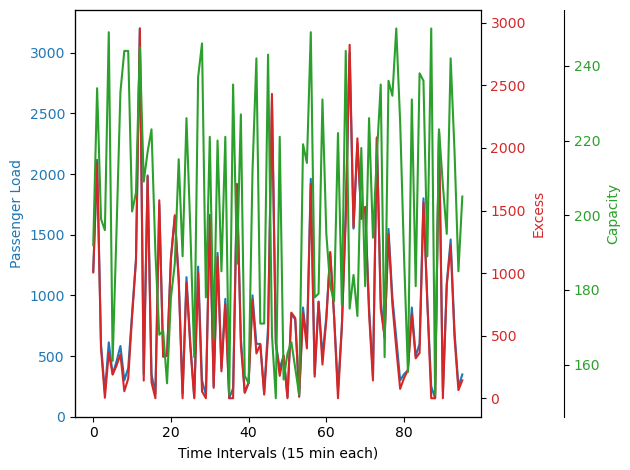

In [3]:
from gurobipy import Model, GRB, quicksum
import random
import numpy as np

# Constants
nA, nB, nC = 100, 200, 300
N_A, N_B, N_C = 250, 150, 100
nT = 96  # Number of 15-minute intervals in 24 hours
W = 1  # Weight for exceeding capacity
M = 10000  # Large constant for linearizing absolute value

# Randomly generated time-varying capacity for each 15-min interval
mu_t = [random.randint(150, 250) for _ in range(nT)]

# Create a model
m = Model("airport_security")

# Decision Variables
X_A = {(j, t): m.addVar(vtype=GRB.INTEGER, name=f"X_A_{j}_{t}") for j in range(nA) for t in range(nT)}
X_B = {(j, t): m.addVar(vtype=GRB.INTEGER, name=f"X_B_{j}_{t}") for j in range(nB) for t in range(nT)}
X_C = {(j, t): m.addVar(vtype=GRB.INTEGER, name=f"X_C_{j}_{t}") for j in range(nC) for t in range(nT)}
E = {t: m.addVar(vtype=GRB.INTEGER, name=f"E_{t}") for t in range(nT)}
Z = {t: m.addVar(vtype=GRB.INTEGER, name=f"Z_{t}") for t in range(nT)}
B = {t: m.addVar(vtype=GRB.BINARY, name=f"B_{t}") for t in range(nT)}

# Objective Function
m.setObjective(quicksum(Z[t] for t in range(nT)), GRB.MINIMIZE)

# Constraints
for t in range(nT):
    lin_expr = quicksum(X_A[j, t] for j in range(nA)) + \
               quicksum(X_B[j, t] for j in range(nB)) + \
               quicksum(X_C[j, t] for j in range(nC)) + W * E[t] - mu_t[t]
    m.addConstr(Z[t] >= lin_expr)
    m.addConstr(Z[t] >= -lin_expr)
    m.addConstr(Z[t] <= M * B[t])
    m.addConstr(Z[t] >= -M * (1 - B[t]))

for j in range(nA):
    m.addConstr(quicksum(X_A[j, t] for t in range(nT)) == N_A)
for j in range(nB):
    m.addConstr(quicksum(X_B[j, t] for t in range(nT)) == N_B)
for j in range(nC):
    m.addConstr(quicksum(X_C[j, t] for t in range(nT)) == N_C)

for t in range(nT):
    m.addConstr(quicksum(X_A[j, t] for j in range(nA)) +
                quicksum(X_B[j, t] for j in range(nB)) +
                quicksum(X_C[j, t] for j in range(nC)) - E[t] <= mu_t[t])

for t in range(nT):
    m.addConstr(E[t] >= 0)

# Solve
m.optimize()

# Prepare data for visualization
if m.status == GRB.Status.OPTIMAL:
    passenger_load = [sum(X_A[j, t].X for j in range(nA)) +
                      sum(X_B[j, t].X for j in range(nB)) +
                      sum(X_C[j, t].X for j in range(nC)) for t in range(nT)]
    excess = [E[t].X for t in range(nT)]